# How “good” is your model, and how can you make it better?

What distinguishes “true artists” from “one-hit wonders” in machine learning is an understanding of how a model performs with respect to different data. This hands-on tutorial will show you how to use scikit-learn’s model evaluation functions to evaluate different models in terms of accuracy and generalisability, and search for optimal parameter configurations.

## Load the required libraries

In [1]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.cross_validation as cv

from sklearn import preprocessing
from sklearn import metrics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.grid_search import GridSearchCV

%matplotlib inline

/Users/jay/Documents/CEDL/pyenv/lib/python2.7/site-packages/pandas/io/excel.py:626: UserWarning: Installed openpyxl is not supported at this time. Use >=1.6.1 and <2.0.0.
  .format(openpyxl_compat.start_ver, openpyxl_compat.stop_ver))


## Exploring and pre-processing data

The first thing you will need to do in order to work with the WDBC dataset is to read it in from the .csv data file:

In [2]:
data = pd.read_csv("wdbc.csv", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Once the data is converted into a numpy array, construct the data matrix X and the associated class vector y (target variable). 

In [3]:
# Convert to numpy array
dataArray = np.array(data)

# Cast the input data into type float
X = dataArray[:,2:].astype(float)
y = dataArray[:,1]

It is always a good practice to check the dimensionality of the input data

In [4]:
print "X dimensions:", X.shape
print "y dimensions:", y.shape

X dimensions: (569, 30)
y dimensions: (569,)


In our current dataset, the y values are categorical (i.e. they can only take one of a discrete set of values) and have a non-numeric representation ("M" or "B"). This is problematic for scikit-learn algorithms, since they assume numerical values, so we need to map the text categories to numerical representations.

In [5]:
le = preprocessing.LabelEncoder()
le.fit(y)
yTransformed = le.transform(y)
# print yTransformed

An important thing to understand before applying any classification algorithms is how the output labels
are distributed. Are they evenly distributed? Imbalances in distribution of labels can often lead to poor classification results for the minority class even if the classification results for the majority class
are very good.

In [49]:
yFreq = scipy.stats.itemfreq(y)
print yFreq

AttributeError: 'NotImplementedType' object has no attribute 'flat'

***Scale data; include more text on that.... blah blah...  *****

In [7]:
Xauto = preprocessing.StandardScaler().fit_transform(X)

You can visualise the relationship between two variables (radius and perimeter of the tumour) using a simple scatter plot. To illustrate, let’s plot the first two variables against each other:

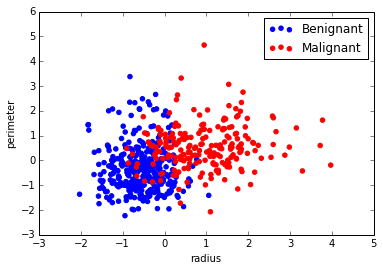

In [66]:
plt.scatter(x = Xauto[yTransformed==0,0], y = Xauto[yTransformed==0,1], color = 'b', label='Benignant')
plt.scatter(x = Xauto[yTransformed==1,0], y = Xauto[yTransformed==1,1], color = 'r', label='Malignant')
plt.xlabel("radius")
plt.ylabel("perimeter")
plt.legend()
plt.show()

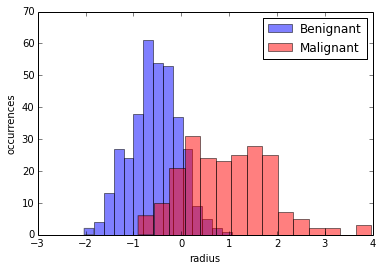

In [68]:
plt.hist(Xauto[yTransformed==0,0], color='b', alpha=.5, label='Benignant', bins=15)
plt.hist(Xauto[yTransformed==1,0], color='r', alpha=.5, label='Malignant', bins=15)
plt.xlabel("radius")
plt.ylabel("occurrences")
plt.legend()
plt.show()

## Training and testing a classifier

Training and testing a classification model on the same dataset is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data (poor generalisation). <br/> 

To use different datasets for training and testing, we need to split the breast cancer dataset into two disjoint sets: train and test (**Holdout method**). <br/> 

In [9]:
XTrain, XTest, yTrain, yTest = cv.train_test_split(Xauto, yTransformed, test_size= 0.3, random_state=5)

XTrain and yTrain are the two arrays you use to train your model. XTest and yTest are the two arrays that you use to evaluate your model. By default, scikit-learn splits the data so that 25% of it is used for testing, but you can also specify the proportion of data you want to use for training and testing (in this case, 30% is used for testing).

You can check the sizes of the different training and test sets by using the shape attribute:

In [10]:
print "XTrain dimensions:", XTrain.shape
print "yTrain dimensions:", yTrain.shape
print "XTest dimensions:",  XTest.shape
print "yTest dimensions:",  yTest.shape

XTrain dimensions: (398, 30)
yTrain dimensions: (398,)
XTest dimensions: (171, 30)
yTest dimensions: (171,)


## KNN

To build KNN models using scikit-learn, you will be using the **KNeighborsClassifier** function, which allows you to set the value of K using the *n_neighbors* parameter. The optimal choice of the value K is highly data-dependent: in general a larger K suppresses the effects of noise, but makes the classification boundaries less distinct. <br/>

### Uniform weights

We are going to start by trying two predefined random values of K and compare their performance:

In [11]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn3.fit(XTrain, yTrain)
yPredK3 = knn3.predict(XTest)

print metrics.classification_report(yTest, yPredK3)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, yPredK3), 2)

             precision    recall  f1-score   support

          0       0.96      0.99      0.97       110
          1       0.98      0.92      0.95        61

avg / total       0.97      0.96      0.96       171

Overall Accuracy: 0.96


In [12]:
knn10 = KNeighborsClassifier(n_neighbors=10)
knn10.fit(XTrain, yTrain)
yPredK10 = knn10.predict(XTest)

print metrics.classification_report(yTest, yPredK10)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, yPredK10), 2)

             precision    recall  f1-score   support

          0       0.96      0.99      0.98       110
          1       0.98      0.93      0.96        61

avg / total       0.97      0.97      0.97       171

Overall Accuracy: 0.97


### Distance weights

Under some circumstances, it is better to give more importance ("weight" in computing terms) to nearer neighbours. When weights = "distance", weights are assigned to the training data points in a way that is proportional to the inverse of the distance from the query point. In other words, nearer neighbours contribute more to the fit. <br/>

What if we use weights based on distance? Does it improve the overall performance? 

In [13]:
knnW3 = KNeighborsClassifier(n_neighbors=3, weights='distance')
knnW3.fit(XTrain, yTrain)
predictedW3 = knnW3.predict(XTest)

print metrics.classification_report(yTest, predictedW3)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, predictedW3), 2)

             precision    recall  f1-score   support

          0       0.96      0.99      0.97       110
          1       0.98      0.92      0.95        61

avg / total       0.97      0.96      0.96       171

Overall Accuracy: 0.96


### Comparison

In [14]:
def plotvector(XTrain, yTrain, XTest, yTest, weights, upperLim = 310):
    results = []
    for n in range(1, upperLim, 4):
        clf = KNeighborsClassifier(n_neighbors = n, weights = weights)
        clf = clf.fit(XTrain, yTrain)
        preds = clf.predict(XTest)
        accuracy = clf.score(XTest, yTest)
        results.append([n, accuracy])
    results = np.array(results)
    return(results)

def plotaccuracy(XTrain, yTrain, XTest, yTest, upperLim):
    pltvector1 = plotvector(XTrain, yTrain, XTest, yTest, weights = "uniform",  upperLim=upperLim)
    pltvector2 = plotvector(XTrain, yTrain, XTest, yTest, weights = "distance", upperLim=upperLim)
    line1 = plt.plot(pltvector1[:,0], pltvector1[:,1], label = "uniform",  color='blue')
    line2 = plt.plot(pltvector2[:,0], pltvector2[:,1], label = "distance", color='red')
    plt.legend(loc=3)
    plt.ylim(0.85, 1)
    plt.title("Accuracy with Increasing K")
    plt.grid()

This function plots the accuracies of applying the KNN algorithms with different k values for both uniform and distance weights up to a k value of 100.

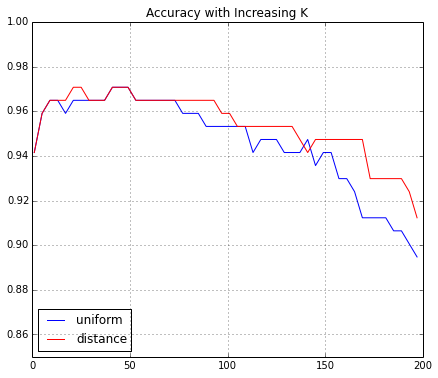

In [15]:
plt.figure(figsize=(7, 6))
plotaccuracy(XTrain, yTrain, XTest, yTest, 200)

## Tuning KNN parameters

The sklearn library has a grid search function, GridSearchCV, that allows us to search for the optimum
combination of parameters by evaluating models trained with a particular algorithm with all
parameter combinations. You can use this function to search for a parametisation of the KNN algorithm
that gives a more optimal model.

In [16]:
# We want to use odd numbers of k to avoid ties

n_neighbors = np.arange(1, 50, 2)
weights     = ['uniform','distance']

# GridSearchCV accepts parameter values  only as a dictionary

parameters = [{'n_neighbors': n_neighbors, 'weights': weights}]
grid = GridSearchCV(KNeighborsClassifier(), parameters, cv= 10)
grid.fit(XTrain, yTrain)

print "The best parameters are: n_neighbors=", grid.best_params_['n_neighbors'],"and weight=",grid.best_params_['weights']


The best parameters are: n_neighbors= 3 and weight= uniform


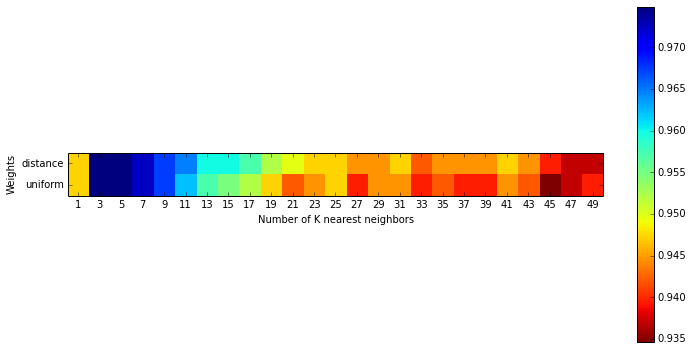

In [17]:
score_dict = grid.grid_scores_
scores = [x[1] for x in score_dict]
scores = np.array(scores).reshape(len(n_neighbors), len(weights))
scores = np.transpose(scores)

# Make a heatmap with the performance
plt.figure(figsize=(12, 6))
plt.imshow(scores, interpolation='nearest', origin='higher', cmap=plt.cm.get_cmap('jet_r'))

plt.colorbar()
plt.xticks(np.arange(len(n_neighbors)), n_neighbors)
plt.yticks(np.arange(len(weights)), weights)
plt.xlabel('Number of K nearest neighbors')
plt.ylabel('Weights')
plt.show()

When evaluating the resulting model it is important to do it on held-out samples that were not seen during the grid search process (XTest). <br/> So, we are testing our independent XTest dataset using the optimised model:

In [18]:
knn = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'], weights = grid.best_params_['weights'])
knn.fit(XTrain, yTrain)
yPredKnn = knn3.predict(XTest)

print metrics.classification_report(yTest, yPredKnn)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, yPredKnn), 2)

             precision    recall  f1-score   support

          0       0.96      0.99      0.97       110
          1       0.98      0.92      0.95        61

avg / total       0.97      0.96      0.96       171

Overall Accuracy: 0.96


The best parameters are: n_neighbors= 7


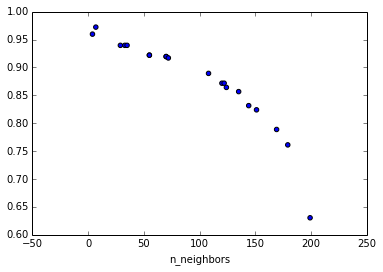

In [126]:
#### CHECK THIS ####
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats.distributions import randint
param_dist = {'n_neighbors': randint(1,200)}
random_search = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist, n_iter=20)
random_search.fit(XTrain, yTrain)

print "The best parameters are: n_neighbors=", random_search.best_params_['n_neighbors']

neig = [score_tuple[0]['n_neighbors'] for score_tuple in random_search.grid_scores_]
res = [score_tuple[1] for score_tuple in random_search.grid_scores_]
plt.scatter(neig, res)
plt.xlabel('n_neighbors')
plt.show()

## Random Forest

Random forests aggregates a group of decision trees into an ensembles. It adds randomness in 2 ways, one is by sampling with replacement(bootstrap sampling) from the training data and then fitting a tree for each of these samples. Then splitting on a feature in the decision tree, random forest considers random subset of variables to split on. <br/>

One of the most important tuning parameters in building a random forest is the number of trees to construct.

In [19]:
clf = RandomForestClassifier(n_jobs=2)
clf.fit(XTrain, yTrain)
predRF = clf.predict(XTest)

print metrics.classification_report(yTest, predRF)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, predRF),2)

             precision    recall  f1-score   support

          0       0.97      0.98      0.98       110
          1       0.97      0.95      0.96        61

avg / total       0.97      0.97      0.97       171

Overall Accuracy: 0.97


### Bagging
In ensemble algorithms, bagging methods form a class of algorithms which build several instances of a black-box estimator on random subsets of the original training set and then aggregate their individual predictions to form a final prediction. These methods are used as a way to reduce the variance of a base estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it. In many cases, bagging methods constitute a very simple way to improve with respect to a single model, without making it necessary to adapt the underlying base algorithm. As they provide a way to reduce overfitting, bagging methods work best with strong and complex models (e.g., fully developed decision trees), in contrast with boosting methods which usually work best with weak models (e.g., shallow decision trees).

In [47]:
# Example code for a model and a set of grid-search parameters
model = RandomForestClassifier()
parameters = [{"n_estimators": [250, 500, 1000]}]
sample_leaf_options = [1,5,10,50,100,200,500]
 
# Returns the best configuration for a model using crosvalidation
# and grid search
def best_config(model, parameters, train_instances):
#     log_info('Grid search for... ' + name)
    clf = GridSearchCV(model, parameters, cv=5, scoring="accuracy", verbose=5, n_jobs=4)
    clf.fit(train_instances)
    best_estimator = clf.best_estimator_
    log_info('Best hyperparameters: ' + str(clf.best_params_))
 
    return [str(clf.best_params_), clf.best_score_,
            best_estimator]

best_config(model, parameters, XTrain)

ValueError: Expected array-like (array or non-string sequence), got None

### Boosting

The following example shows how to fit an AdaBoost classifier with 100 weak learners. The number of weak learners is controlled by the parameter n_estimators. The learning_rate parameter controls the contribution of the weak learners in the final combination. By default, weak learners are decision stumps. Different weak learners can be specified through the base_estimator parameter. The main parameters to tune to obtain good results are n_estimators and the complexity of the base estimators (e.g., its depth max_depth or minimum required number of samples at a leaf min_samples_leaf in case of decision trees).

In [41]:
from sklearn.cross_validation import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

iris = load_iris()
clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, iris.data, iris.target)
scores.mean() 

0.95996732026143794

## SVMs
### Linear SVMs

Linear SVMs using the default value for C

In [43]:
# Default C parameter
linearSVM = SVC(kernel='linear')
linearSVM.fit(XTrain, yTrain)
yPredLinear = linearSVM.predict(XTest)

print metrics.classification_report(yTest, yPredLinear)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, yPredLinear),2)

             precision    recall  f1-score   support

          0       0.98      0.99      0.99       110
          1       0.98      0.97      0.98        61

avg / total       0.98      0.98      0.98       171

Overall Accuracy: 0.98


### Non-linear SVMs

Non-linear SVMs using the default values for C and gamma

In [24]:
# Default C and gamma parameters
rbfSVM = SVC(kernel='rbf', C=1.0, gamma=0.0)
rbfSVM.fit(XTrain, yTrain)
yPredRBF = rbfSVM.predict(XTest)

print metrics.classification_report(yTest, yPredRBF)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, yPredRBF),2)

             precision    recall  f1-score   support

          0       0.98      0.99      0.99       110
          1       0.98      0.97      0.98        61

avg / total       0.98      0.98      0.98       171

Overall Accuracy: 0.98


### Hyperparameter Tuning

Optimising the hyperparameters using a coarse tuning

In [25]:
# Range for gamma and Cost hyperparameters
g_range = 2. ** np.arange(-15, 5, step=2)
C_range = 2. ** np.arange(-5, 15, step=2)

grid = [{'gamma': g_range, 'C': C_range}]

gridcv = GridSearchCV(SVC(), param_grid=grid, cv= cv.KFold(n=XTrain.shape[0], n_folds=5))
gridcv.fit(XTrain, yTrain)

bestG = np.log2(gridcv.best_params_['gamma']);
bestC = np.log2(gridcv.best_params_['C']);

print "The best parameters are: gamma=", bestG, " and Cost=", bestC

The best parameters are: gamma= -9.0  and Cost= 3.0


Plot the results of the grid search using a heatmap

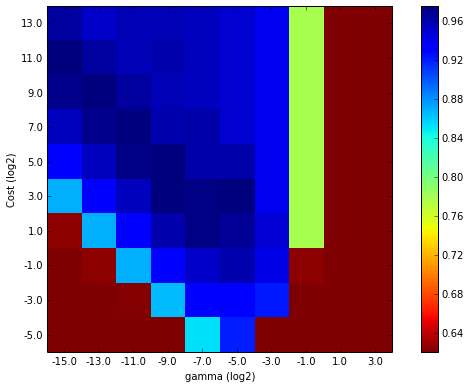

In [26]:
# plot the scores of the grid
# grid_scores_ contains parameter settings and scores
score_dict = gridcv.grid_scores_

# We extract just the scores
scores = [x[1] for x in score_dict]
scores = np.array(scores).reshape(len(C_range), len(g_range))

# Make a heatmap with the performance
plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', origin='higher', cmap=plt.cm.get_cmap('jet_r'))
plt.xlabel('gamma (log2)')
plt.ylabel('Cost (log2)')
plt.colorbar()
plt.xticks(np.arange(len(g_range)), np.log2(g_range))
plt.yticks(np.arange(len(C_range)), np.log2(C_range))
plt.show()

Finally, testing with the optimised model (best hyperparameters):

In [27]:
rbfSVM = SVC(kernel='rbf', C=gridcv.best_params_['C'], gamma=gridcv.best_params_['gamma'])
rbfSVM.fit(XTrain, yTrain)

predictions = rbfSVM.predict(XTest) 

print metrics.classification_report(yTest, predictions)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, predictions),2)

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       110
          1       1.00      0.97      0.98        61

avg / total       0.99      0.99      0.99       171

Overall Accuracy: 0.99


## Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression
l_regression = LogisticRegression()
l_regression.fit(XTrain, yTrain)
net_prediction = l_regression.predict(XTest)

print metrics.classification_report(yTest, net_prediction)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, net_prediction),2)

             precision    recall  f1-score   support

          0       0.98      0.99      0.99       110
          1       0.98      0.97      0.98        61

avg / total       0.98      0.98      0.98       171

Overall Accuracy: 0.98


In [136]:
# Range for gamma and Cost hyperparameters
pen = ['l1','l2']
C_range = 2. ** np.arange(-5, 15, step=2)

grid = [{'C': C_range, 'penalty': pen}]

gridcv = GridSearchCV(LogisticRegression(), param_grid=grid, cv= cv.KFold(n=XTrain.shape[0], n_folds=5))
gridcv.fit(XTrain, yTrain)

best_c = gridcv.best_params_['C']
best_penalty = gridcv.best_params_['penalty']

print "The best parameters are: cost=", best_c, " and penalty=", best_penalty

The best parameters are: cost= 0.5  and penalty= l2


## Neural Networks

In [30]:
from multilayer_perceptron import multilayer_perceptron

In [31]:
nnet = multilayer_perceptron.MultilayerPerceptronClassifier(activation='logistic',
                                                            hidden_layer_sizes=(2), learning_rate_init=.5)
nnet.fit(XTrain, yTrain)
net_prediction = nnet.predict(XTest)

print metrics.classification_report(yTest, net_prediction)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, net_prediction),2)

             precision    recall  f1-score   support

          0       0.98      0.98      0.98       110
          1       0.97      0.97      0.97        61

avg / total       0.98      0.98      0.98       171

Overall Accuracy: 0.98


In [127]:
# Range for gamma and Cost hyperparameters
layer_size_range = [(3,2),(10,10),(2,2,2),10,5] # different networks shapes
learning_rate_range = np.linspace(.1,1,3)

grid = [{'hidden_layer_sizes': layer_size_range, 'learning_rate_init': learning_rate_range}]

gridcv = GridSearchCV(multilayer_perceptron.MultilayerPerceptronClassifier(), 
                      param_grid=grid, cv= cv.KFold(n=XTrain.shape[0], n_folds=5))
gridcv.fit(XTrain, yTrain)

best_size = gridcv.best_params_['hidden_layer_sizes']
best_best_lr = gridcv.best_params_['learning_rate_init']

print "The best parameters are: hidden_layer_sizes=", best_size, " and learning_rate_init=", best_best_lr

The best parameters are: hidden_layer_sizes= (3, 2)  and learning_rate_init= 0.1


In [33]:
nnet = multilayer_perceptron.MultilayerPerceptronClassifier(hidden_layer_sizes=(2, 2, 2), learning_rate_init=.1)
nnet.fit(XTrain, yTrain)
net_prediction = nnet.predict(XTest)

print metrics.classification_report(yTest, net_prediction)
print "Overall Accuracy:", round(metrics.accuracy_score(yTest, net_prediction),2)

             precision    recall  f1-score   support

          0       0.98      0.98      0.98       110
          1       0.97      0.97      0.97        61

avg / total       0.98      0.98      0.98       171

Overall Accuracy: 0.98


In [34]:
cv.cross_val_score

TypeError: 'module' object is not callable